# Dynamic Regression
Yang Xi<br>
24 Aug, 2021

## Monthly Sales Data of an Item

The transformation is to fit the model: y = y0 x cm^bc x dm^bd x e

Covert to linear by log transformation: Y = b0 + bcXc + bdXd + e

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>],
      dtype=object)

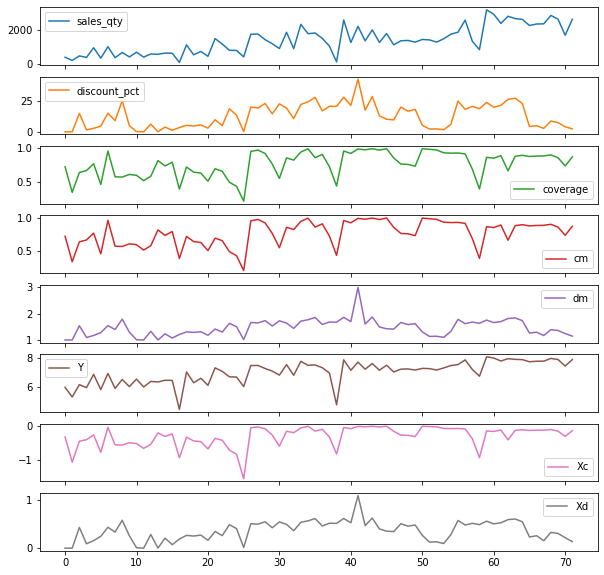

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox

dfItemC = pd.read_csv('data/time_series_monthly_C.csv')

# Data Preparation
def GetLine(xa, ya, xb, yb, v):
    return v*(ya-yb)/(xa-xb) + (yb*xa - ya*xb)/(xa-xb)

def TransformDiscount(d):
    x1, y1, x2, y2, x3, y3, x4, y4, x5, y5 = 0, 1, 5, 1.3, 30, 1.9, 40, 3, 100, 3
    if d < x2:
        d = GetLine(x1,y1,x2,y2,d)
    elif d < x3:
        d = GetLine(x2,y2,x3,y3,d)
    elif d < x4:
        d = GetLine(x3,y3,x4,y4,d)
    else:
        d = GetLine(x4,y4,x5,y5,d)
    return d

dfItemC['coverage'] = 1 - dfItemC['stock_out_pct']/100
dfItemC = dfItemC[['first_date', 'sales_qty', 'discount_pct', 'coverage']]

dfItemC['cm'] = dfItemC['coverage']
dfItemC['dm'] = dfItemC['discount_pct'].apply(lambda d: TransformDiscount(d))
dfItemC['Y'] = dfItemC['sales_qty'].apply(np.log)
dfItemC['Xc'] = dfItemC['cm'].apply(np.log)
dfItemC['Xd'] = dfItemC['dm'].apply(np.log)

dfItemC.plot(subplots=True, figsize=(10,10))

### Train/Test Sets and Performance Measures

In [2]:
indexTrain = dfItemC['first_date'] < '2013-01-01'
dfItemC_train = dfItemC[indexTrain].copy()
print(f"Train set contains {len(dfItemC_train)} rows.")
dfItemC_test = dfItemC[~indexTrain]
print(f"Test set contains {len(dfItemC_test)} rows.")

# Smooth outliers in train set
def SmoothOutlier(dfTrain):
    indexOutlier1 = (dfTrain['sales_qty']==0)
    indexOutlier2 = (dfTrain['coverage']==0)
    indexOutlier3 = (dfTrain['discount_pct'] < dfTrain['discount_pct'].mean()) & (dfTrain['sales_qty'] > dfTrain['sales_qty'].mean() + 2*dfTrain['sales_qty'].std())
    indexOutlier = indexOutlier1 | indexOutlier2 | indexOutlier3
    dfTrain.loc[indexOutlier, 'Y'] = np.nan
    return dfTrain, indexOutlier

dfItemC_train, indexOutlier = SmoothOutlier(dfItemC_train)

Train set contains 60 rows.
Test set contains 12 rows.


In [3]:
def rmse_e(e, digits=2):
    return np.round(np.sqrt(np.mean(e**2)), digits)
def rmse(pred, actual, digits=2):
    return rmse_e(pred - actual, digits)

def mase(pred, actual, digits=2):
    n = len(pred)
    return np.round(np.sum(np.abs(pred-actual))/np.sum(np.abs(np.diff(actual)))*(n-1)/n, digits)

def CheckResiduals(res):
    plotACF = plot_acf(res, fft=False, zero=False, alpha=0.05)
    dfBox = acorr_ljungbox(res, lags=[len(res)-1], return_df=True)
    return plotACF, dfBox

h = 12 # forecast for 12-month

### ARIMAX

In [4]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

np.random.seed(1)
fitSARIMA = SARIMAX(dfItemC_train['Y'], dfItemC_train[['Xc', 'Xd']], \
    order=(1,1,1), trend='c').fit()
fitSARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      Y   No. Observations:                   60
Model:               SARIMAX(1, 1, 1)   Log Likelihood                 -28.500
Date:                Wed, 25 Aug 2021   AIC                             69.000
Time:                        21:56:26   BIC                             81.465
Sample:                             0   HQIC                            73.866
                                 - 60                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0268      0.030      0.890      0.373      -0.032       0.086
Xc             1.3797      0.169      8.151      0.000       1.048       1.711
Xd             0.5039      0.480      1.050      0.294      -0.437       1.444
ar.L1         -0.3213      0.220     -1.458      0.145      -0.753       0.111
ma.L1         -0.5468      0.186     -2.935      0.003      -0.912      -0.182
sigma2         0.1518      0.028      5.491      0.000       0.098       0.206
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                90.07
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -1.57
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.17
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

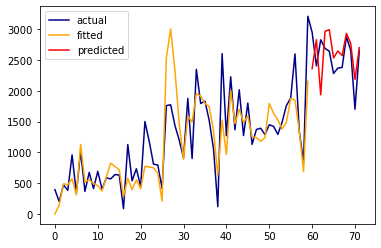

In [5]:
nTrain = len(dfItemC_train)
predSARIMA = fitSARIMA.predict(exog=dfItemC_test[['Xc', 'Xd']], start=nTrain, end=nTrain+h-1)
predSARIMA = np.exp(predSARIMA)

line1, = plt.plot(dfItemC['sales_qty'], color='darkblue')
line2, = plt.plot(np.exp(fitSARIMA.fittedvalues), color='orange')
line3, = plt.plot(predSARIMA, color='red')
plt.legend([line1, line2, line3], ['actual', 'fitted', 'predicted'])

,lb_stat,lb_pvalue
59,28.485912,0.999733


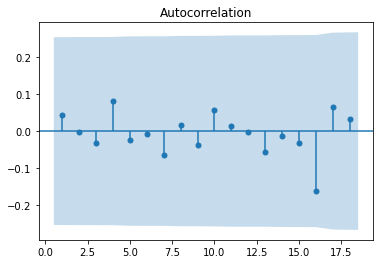

In [6]:
plotACF, dfBox = CheckResiduals(fitSARIMA.resid)
dfBox

In [7]:
maseSARIMA = mase(predSARIMA, dfItemC_test['sales_qty'])
rmseSARIMA = rmse(predSARIMA, dfItemC_test['sales_qty'])
print(f"Holt-Winter's model: MASE = {maseSARIMA}, RMSE = {rmseSARIMA}.")

Holt-Winter's model: MASE = 0.86, RMSE = 403.75.
